<a href="https://colab.research.google.com/github/sanjana-mishra/8PointAlgo/blob/main/Detectron2_Crochet_Instance_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Train custom instance segmentation model using Detectron2

**Installation of Detectron2**

In [21]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.


In [22]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [23]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

The default models are trained on natural images, using this section to run a reference image. **Running a pre-trained model on a random image.**

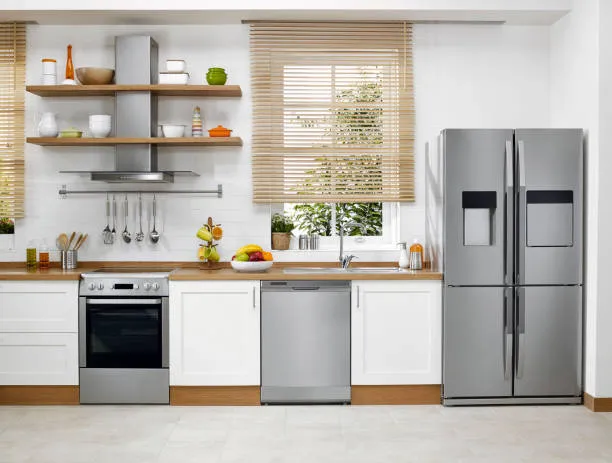

In [24]:
im = cv2.imread("/content/kitchen.webp")
cv2_imshow(im)

Create a detectron2 config and a detectron2 DefaultPredictor to run inference on this image.

In [25]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold
# Find a model from detectron2's model zoo.  https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[04/03 21:43:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


In [26]:
# outputs - tensors and bounding boxes.
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

tensor([72, 69, 44, 44, 58, 45, 45, 44, 44, 49, 44, 75, 45, 39, 39, 39, 71, 58,
        72, 39, 46, 45, 39, 47, 47, 46, 45, 44, 71, 44], device='cuda:0')
Boxes(tensor([[436.2068, 126.4250, 583.1385, 405.3383],
        [ 78.3193, 272.0055, 170.8189, 401.6665],
        [150.3688, 198.9648, 159.2671, 242.1314],
        [122.3776, 198.8635, 130.7803, 242.9120],
        [270.9488, 211.4505, 294.9621, 249.4300],
        [230.4740, 259.5655, 274.0257, 273.0279],
        [ 75.2111,  67.6933, 114.9453,  85.1827],
        [136.5044, 199.5819, 143.6766, 241.8548],
        [ 57.4076, 233.4466,  68.1105, 249.9619],
        [262.2229, 251.7546, 272.7456, 260.3243],
        [102.3826, 197.4551, 113.8764, 244.8872],
        [ 38.2868, 112.5457,  58.9556, 136.1763],
        [160.9030, 125.5478, 184.9181, 137.6765],
        [397.7482, 241.6111, 408.9312, 269.2491],
        [409.4209, 239.1566, 423.3644, 270.5257],
        [191.3101, 106.0119, 203.0144, 137.1347],
        [282.5988, 265.7739, 405.1901, 2

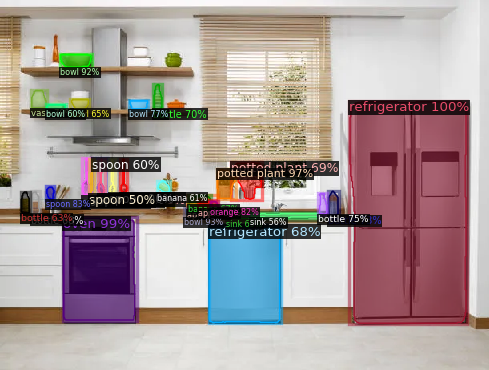

In [27]:
# `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

since the model works on a natural image, will now test of an image from crochet dataset.

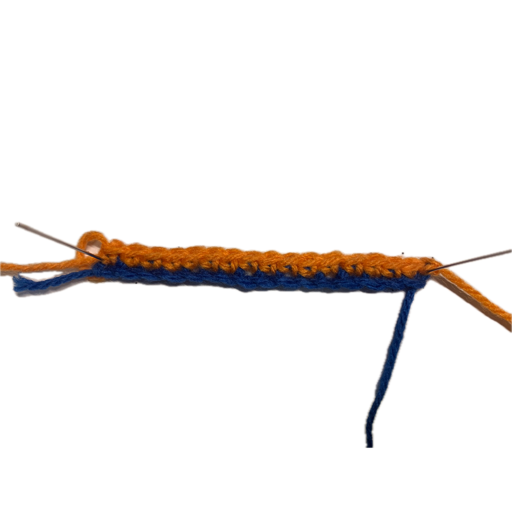

In [28]:
sci_im = cv2.imread("/content/data/test/test_1.png")
cv2_imshow(sci_im)

Some predictions. Bound to get incorrcect reuslts as the model mask_rcnn_R_50_FPN_3x has no idea about my sample and was not trained on crochet stitches.

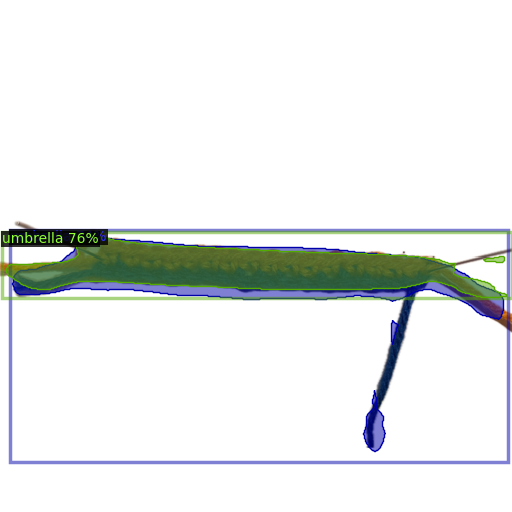

In [29]:
sci_outputs = predictor(sci_im)
sci_v = Visualizer(sci_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))
sci_out = sci_v.draw_instance_predictions(sci_outputs["instances"].to("cpu"))
cv2_imshow(sci_out.get_image()[:, :, ::-1])

As expected, as there are no crochet items in COCO, the model performs poorly. Here there is an umbrella, can get absolutely nothing recognized as well.

# Train on a crochet stitch dataset

Importing the necessary function to register datasets in the COCO format. Registering both the training and validation datasets. Working with training (and validation) data that is is the coco format where there is a single JSON file that describes all the annotations from all training images. <p>
Naming convention: training data is 'my_dataset_train' and the validation data is 'my_dataset_val'.



In [34]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train_2", {}, "/content/data/train/anno_train.json", "/content/data/train")
register_coco_instances("my_dataset_val_2", {}, "/content/data/val/anno_val.json", "/content/data/val")

Extract the metadata and dataset dictionaries for both training and validation datasets. These can be used later for other purposes, like visualization, model training, evaluation, etc.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [35]:
train_metadata = MetadataCatalog.get("my_dataset_train_2")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train_2")

[04/03 21:45:41 d2.data.datasets.coco]: Loaded 23 images in COCO format from /content/data/train/anno_train.json


In [36]:
val_metadata = MetadataCatalog.get("my_dataset_val_2")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val_2")


[04/03 21:45:43 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/data/val/anno_val.json


In [37]:
from matplotlib import pyplot as plt

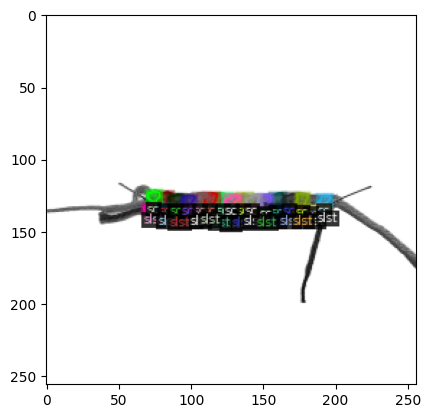

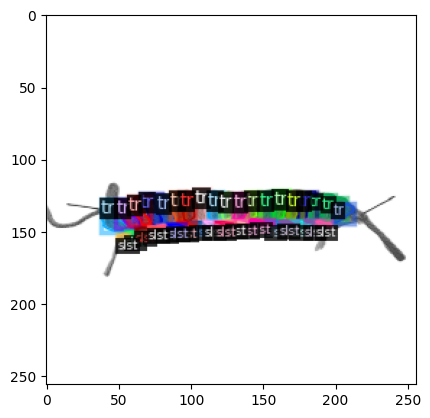

In [39]:
# Visualize some random samples
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# Train

Now we are ready to train a Mask R-CNN model using the Detectron2 library. We start by setting up a configuration file (.cfg) for the model. The configuration file contains many details including the output directory path, training dataset information, pre-trained weights, base learning rate, maximum number of iterations, etc.

In [41]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/models/detectron2_models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train_2",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.0003  # pick a good LR
cfg.SOLVER.MAX_ITER = 5000    # 1000 iterations seems good enough for this dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # Default is 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # We have 4 classes.
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[04/03 21:47:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


Train

In [42]:
trainer.train() #Start the training process

[04/03 21:47:54 d2.engine.train_loop]: Starting training from iteration 0
[04/03 21:48:05 d2.utils.events]:  eta: 0:36:29  iter: 19  total_loss: 7.899  loss_cls: 1.53  loss_box_reg: 0.06909  loss_mask: 0.6923  loss_rpn_cls: 5.357  loss_rpn_loc: 0.3308    time: 0.4284  last_time: 0.4355  data_time: 0.0165  last_data_time: 0.0058   lr: 5.9943e-06  max_mem: 2132M
[04/03 21:48:17 d2.utils.events]:  eta: 0:36:26  iter: 39  total_loss: 4.716  loss_cls: 1.357  loss_box_reg: 0.3846  loss_mask: 0.6915  loss_rpn_cls: 2.105  loss_rpn_loc: 0.2404    time: 0.4387  last_time: 0.4232  data_time: 0.0102  last_data_time: 0.0054   lr: 1.1988e-05  max_mem: 2381M
[04/03 21:48:26 d2.utils.events]:  eta: 0:36:17  iter: 59  total_loss: 3.03  loss_cls: 1.186  loss_box_reg: 0.4968  loss_mask: 0.6897  loss_rpn_cls: 0.3846  loss_rpn_loc: 0.2622    time: 0.4403  last_time: 0.3946  data_time: 0.0109  last_data_time: 0.0239   lr: 1.7982e-05  max_mem: 2381M
[04/03 21:48:34 d2.utils.events]:  eta: 0:36:06  iter: 79  

Save the config file.

In [43]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

<IPython.core.display.Javascript object>

In [46]:
import yaml
# Save the configuration to a config.yaml file
# Save the configuration to a config.yaml file
config_yaml_path = "/content/models/detectron2_models/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

# Inference & evaluation using the trained model

In [52]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[04/03 22:43:42 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/models/detectron2_models/model_final.pth ...


Verify segmentation on random validation images

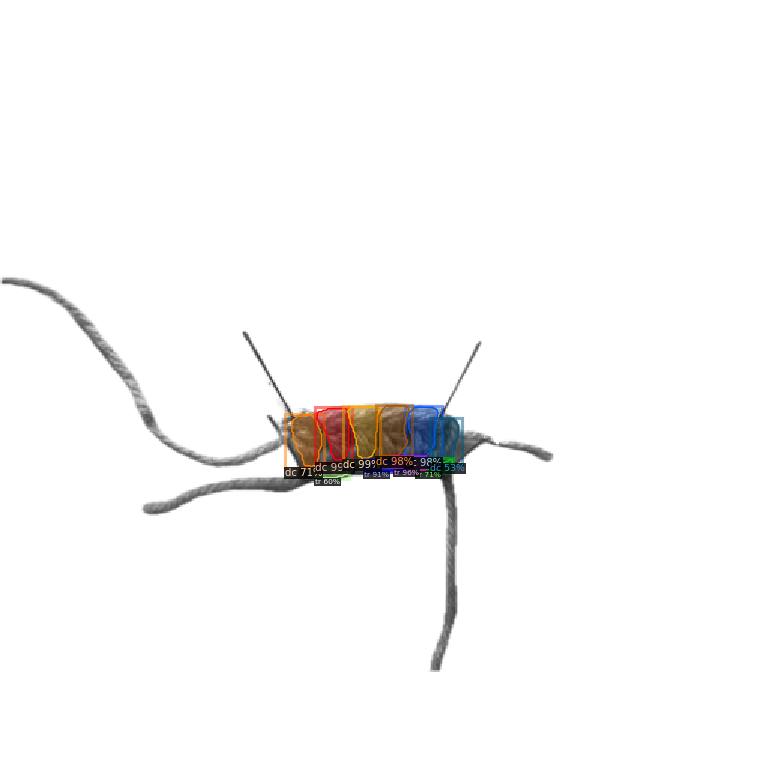

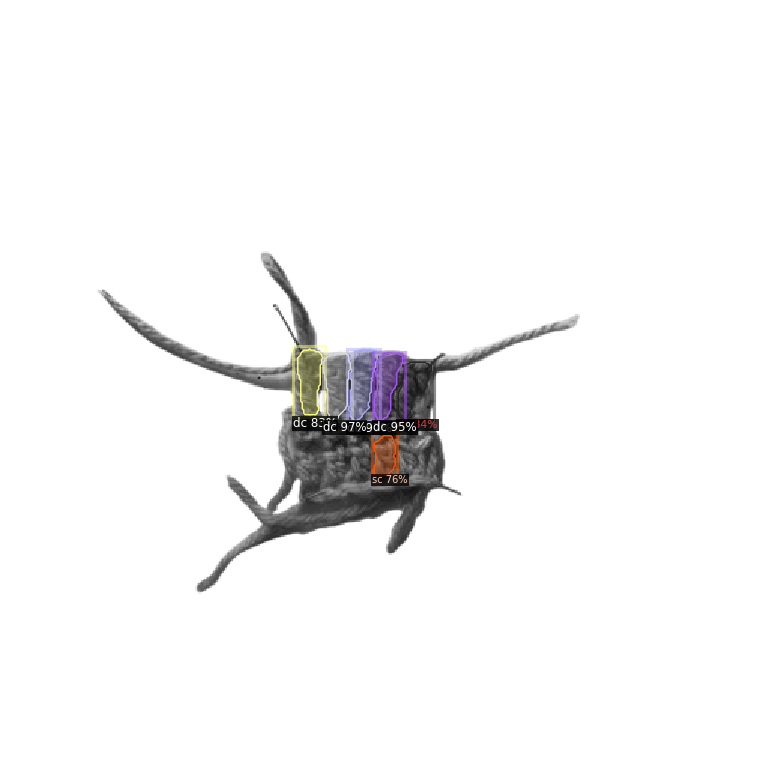

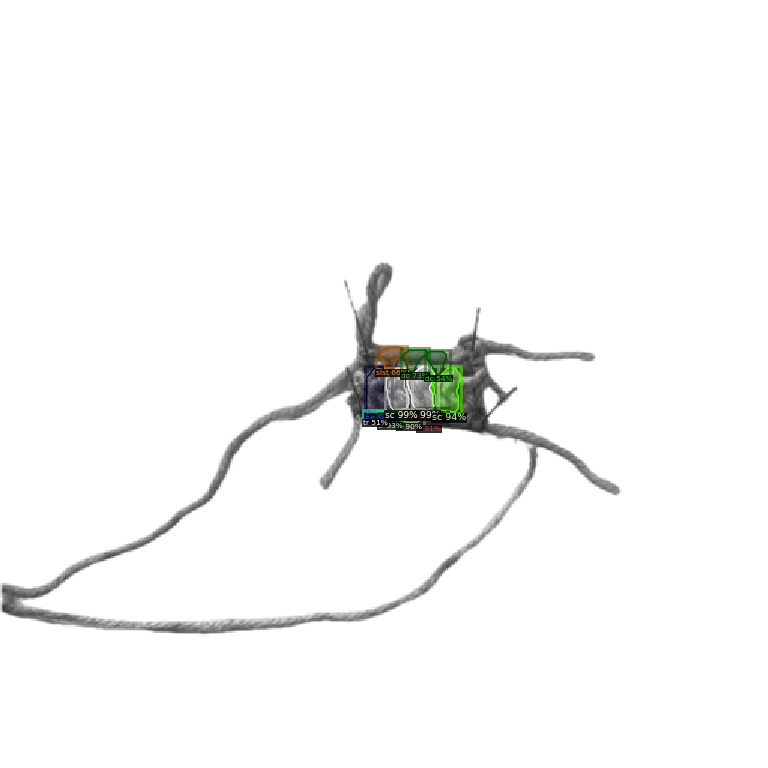

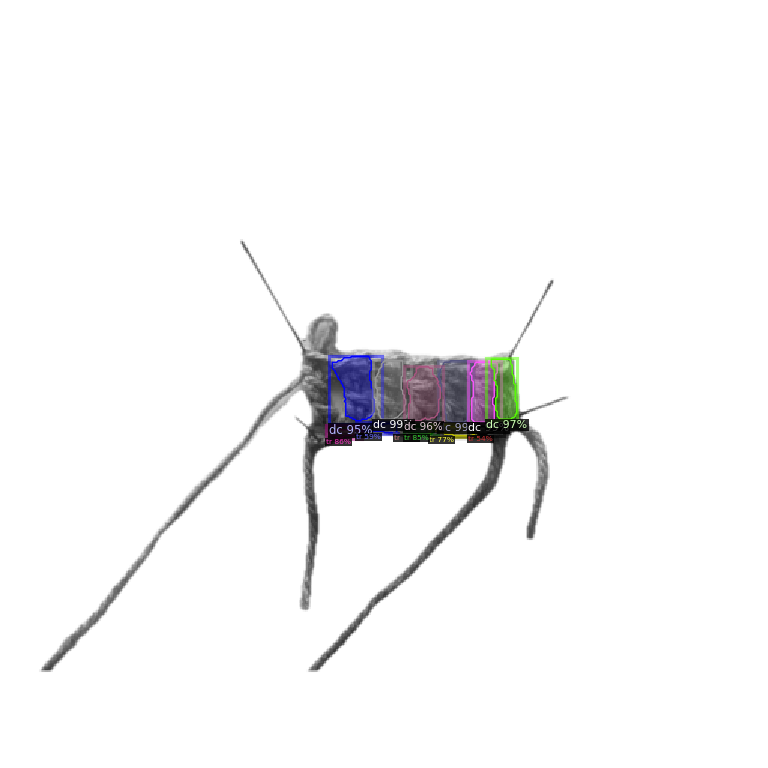

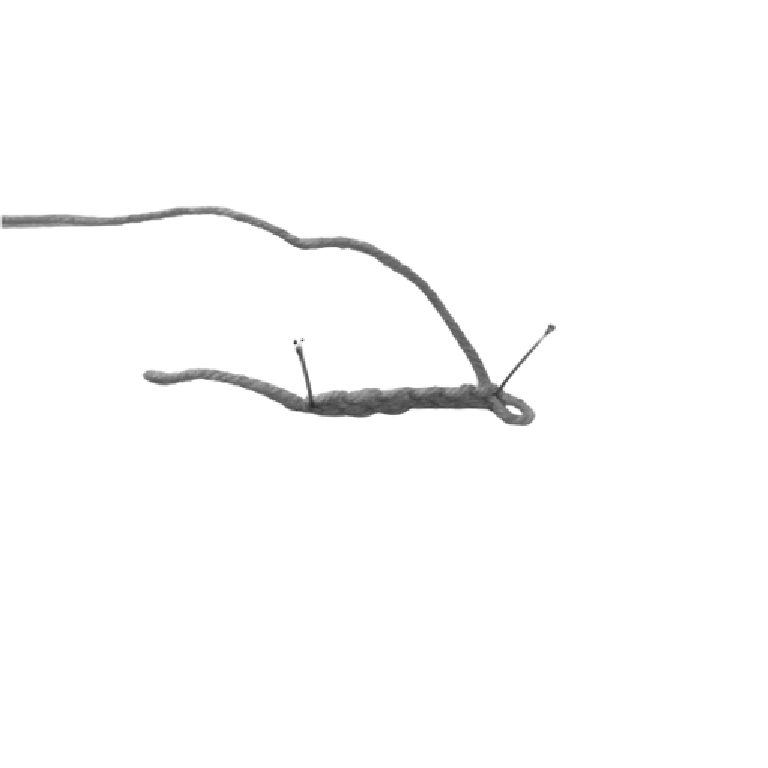

In [66]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 5):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=1.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Average precision and recall.

In [61]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_val_2", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_val_2")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[04/03 22:48:45 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[04/03 22:48:45 d2.data.datasets.coco]: Loaded 5 images in COCO format from /content/data/val/anno_val.json
[04/03 22:48:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/03 22:48:45 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[04/03 22:48:45 d2.data.common]: Serializing 5 elements to byte tensors and concatenating them all ...
[04/03 22:48:45 d2.data.common]: Serialized dataset takes 0.02 MiB
[04/03 22:48:45 d2.evaluation.evaluator]: Start inference on 5 batches
[04/03 22:48:46 d2.evaluation.evaluator]: Total inference time: 0:00:00.139245 (0.139245 s / iter per device, on 1 devices)
[04/03 22:48:46 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:00 (0.083584 s / iter per device, o

**Load a new image and segment it.**

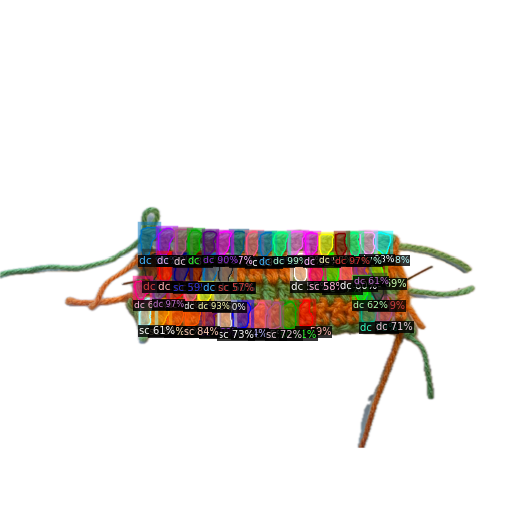

In [73]:
new_im = cv2.imread("/content/data/test/train_25.png")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])


**Process multiple images in a directory and save the results in an output directory**

In [70]:
# Directory path to the input images folder
input_images_directory = "/content/data/test"

# Output directory where the segmented images will be saved
output_directory = "/content/visual_results"  # Replace this with the path to your desired output directory

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)  # Format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")

AttributeError: 'NoneType' object has no attribute 'shape'

# END